# Notebook 13 b) Binary Sentiment Model Using Neural Networks

This notebook seeks to train a model to predict sentiment on the full dataset based only on the noun phrases previously extracted but using neural network models instead of machine learning. The output of this model is BINARY - positive or negative.

* Section 1 - Import libraries and data
* Section 2 - Data preprocessing
* Section 3 - Building a sentiment model (Models 1 to 5 based on the best simple networks from Notebook 8)
* Section 4 - Summary results table

Datasets need to run file:
* combined_sentiment.csv
* combined_sentiment_test.csv

Models saved to:
* SentimentModels1
* SentimentModels2
* SentimentModels3
* SentimentModels4
* SentimentModels5

Final results:

* results_sentiment.csv


# Section 1: Import libraries and data

In [117]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,LSTM,Dropout,SpatialDropout1D,Conv1D,GlobalMaxPooling1D,SimpleRNN,LSTM,GRU,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE

import os
import pickle

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [118]:
# Bring in training and test sets from Notebook 11 (visualising topic models)
df_train = pd.read_csv("combined_sentiment.csv",index_col = 0)
df_test = pd.read_csv("combined_sentiment_test.csv",index_col = 0)

In [119]:
# Combine train and test set
df_combined_all = pd.concat([df_train, df_test],axis = 0,ignore_index = True)
df_combined_all.shape

(73027, 15)

# Section 2: Data preprocessing

In [120]:
# Choose columns, replace incorrect category label and relabel columns
df_train = df_train[["OrigInd","Category","noun_phrases","Topic Count","Sentiment","Score"]]
df_train.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]
df_test = df_test[["OrigInd","Category","noun_phrases","Topic","Sentiment","Score"]]
df_test["Category"].replace({"Attract": "Attractions"}, inplace=True)
df_test.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]

In [121]:
df_combined_all.head(2)

,Unnamed: 0.1,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count,Topic TFIDF,Sentiment,Score,Sentence,Topic
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,shame accommodation,"['shame', 'accommodation']",VFM,VisitExp,-0.4767,negative,NaN,NaN
1,1,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,night stay december post-christmas,"['night', 'post-christmas']",Hotel Location,Restaurant,0.0000,neutral,NaN,NaN


In [122]:
# Get Polarity distribution
df_combined_all["Score"].value_counts()

neutral     39099
positive    29513
negative     4415
Name: Score, dtype: int64

<BarContainer object of 3 artists>

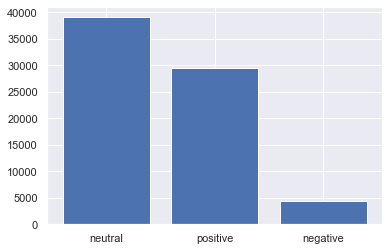

In [123]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])

The dataset is imbalanced

In [124]:
# Drop the neutral sentiment and set 0 to positive and 1 to negative
df_combined_all = df_combined_all[df_combined_all["Score"]!="neutral"]
df_combined_all["Score"].replace({"positive": 0,"negative":1}, inplace=True)

In [125]:
df_combined_all["Score"].value_counts()

0    29513
1     4415
Name: Score, dtype: int64

In [126]:
pos_sampled = df_combined_all[df_combined_all["Score"] == 0].sample(4415)
negative = df_combined_all[df_combined_all["Score"] == 1]
print(pos_sampled.shape, negative.shape)

(4415, 15) (4415, 15)


In [127]:
df_combined_all = pd.concat([pos_sampled, negative], axis = 0, ignore_index = True)
df_combined_all.shape

(8830, 15)

<BarContainer object of 2 artists>

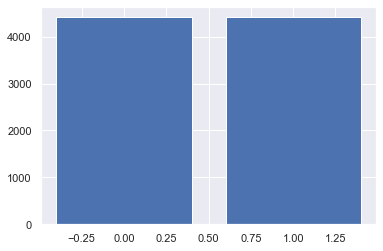

In [128]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])

## Define X and y and split into training, valuation and test sets

In [129]:
X = df_combined_all["noun_phrases"]
y = df_combined_all["Score"]

In [238]:
# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, random_state=0) 

In [239]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

(7064,) (883,) (883,) (7064,) (883,) (883,)


In [240]:
y_train.value_counts()

0    3532
1    3532
Name: Score, dtype: int64

In [241]:
y_val.value_counts()

0    442
1    441
Name: Score, dtype: int64

In [242]:
y_test.value_counts()

1    442
0    441
Name: Score, dtype: int64

## Distribution of noun phrases

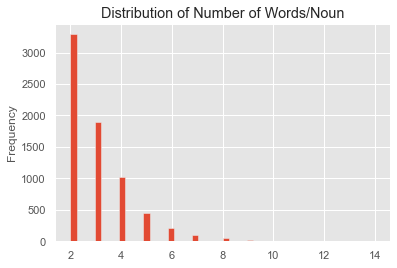

In [243]:
pd.DataFrame(X_train)["noun_phrases"].str.split().apply(len).plot.hist(bins = 50, title = "Distribution of Number of Words/Noun")
plt.show()

In [244]:
pd.DataFrame(X_train)["noun_phrases"].str.split().apply(len).max()

14

## Encoding X values

In [245]:
def tok(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words = 5000)
    tokenizer.fit_on_texts(X_train)
    X_train_s = tokenizer.texts_to_sequences(X_train)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_test)
    X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"), maxlen = 20, padding = "post", truncating = "post", value = 0.0)
    
    return tokenizer, X_train_w, X_val_w, X_test_w

In [246]:
# Apply function to X training, validation and test sets
tok,X_train_w, X_val_w, X_test_w = tok(X_train, X_val, X_test)

In [247]:
# Save tokenizer objects for use in the combined final model
def tok_save(name,tokenizer):
    with open(name, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Save tokenizer pickle files
tok_save('tok_sent.pickle',tok)

In [248]:
index_word = {v:k for k,v in tok.word_index.items()}

In [249]:
#print(tokenizer.word_counts)

In [250]:
#print(tokenizer.word_index)

# Section 3: Building a Sentiment Model

In [251]:
# Visualise the training and test accuracies and losses
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()

In [252]:
# Confusion Matrix function

def class_conf(y_val,y_pred_class):
    classification = classification_report(y_val, y_pred_class)
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred_class)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    print(classification)  

## Sentiment Model 1

In [253]:
# Metrics function

def metric_results(y_val,y_pred_class):
    accuracy = balanced_accuracy_score(y_val, y_pred_class)
    rocauc = roc_auc_score(y_val,y_pred_class)
    precision = precision_score(y_val, y_pred_class, pos_label = 1,average='binary')
    recall = recall_score(y_val, y_pred_class, pos_label = 1, average='binary')
    f1 = f1_score(y_val, y_pred_class, pos_label = 1, average='binary')
          
    
    results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
    return results

In [254]:
# Balanced classes - get weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights

array([1., 1.])

In [255]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 8
epochs = 50

In [256]:
# Simple model with embedding layer and no hidden dense layer, passing the embedding layer to the first layer of the model
model1 = Sequential()
model1.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 20, 16)            96000     
_________________________________________________________________
flatten_48 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 321       
Total params: 96,321
Trainable params: 96,321
Non-trainable params: 0
_________________________________________________________________
None


In [257]:
# The model will use earlystopping if the valuation loss doesn't decrease after 3 epochs
output_dir = 'model_output/SentimentModels1'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [258]:
# Model using keras embeddings
history = model1.fit(X_train_w,y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size
                    )

Epoch 1/50
883/883 - 1s - loss: 0.4328 - accuracy: 0.8698 - val_loss: 0.2032 - val_accuracy: 0.9434
Epoch 2/50
883/883 - 0s - loss: 0.1264 - accuracy: 0.9738 - val_loss: 0.1143 - val_accuracy: 0.9660
Epoch 3/50
883/883 - 0s - loss: 0.0574 - accuracy: 0.9894 - val_loss: 0.0950 - val_accuracy: 0.9706
Epoch 4/50
883/883 - 0s - loss: 0.0306 - accuracy: 0.9946 - val_loss: 0.0891 - val_accuracy: 0.9706
Epoch 5/50
883/883 - 0s - loss: 0.0175 - accuracy: 0.9970 - val_loss: 0.0869 - val_accuracy: 0.9717
Epoch 6/50
883/883 - 0s - loss: 0.0103 - accuracy: 0.9987 - val_loss: 0.0877 - val_accuracy: 0.9672
Epoch 7/50
883/883 - 0s - loss: 0.0062 - accuracy: 0.9999 - val_loss: 0.0907 - val_accuracy: 0.9694
Epoch 8/50
883/883 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0921 - val_accuracy: 0.9728
Epoch 9/50
883/883 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0975 - val_accuracy: 0.9683
Epoch 10/50
883/883 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1006 - val_accuracy: 0.9728

In [259]:
# Print training and test accuracies
loss, accuracy = model1.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_val_w, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Validation Accuracy:  0.9728


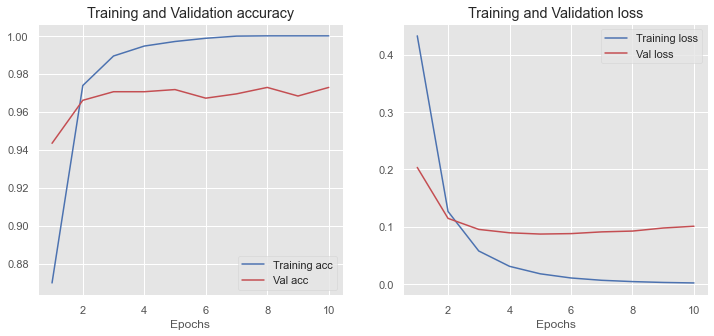

In [260]:
plot_history(history)

In [262]:
# Load model weights from epoch with best validation accuracy
model1.load_weights(output_dir+"/weights.08.hdf5")
#model1.save("Sentiment.h5")

In [263]:
# Get predicted y values and predicted classes
y_pred_prob = model1.predict(X_val_w)
y_pred_class = (model1.predict(X_val_w) > 0.5).astype("int32")

In [264]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.05799797],[0],0
1,[0.011976004],[0],0
2,[0.6369703],[1],1
3,[0.9999032],[1],1
4,[1.7018967e-07],[0],0


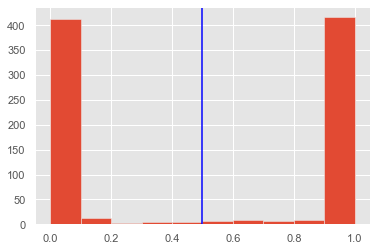

In [265]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       442
           1       0.97      0.98      0.97       441

    accuracy                           0.97       883
   macro avg       0.97      0.97      0.97       883
weighted avg       0.97      0.97      0.97       883



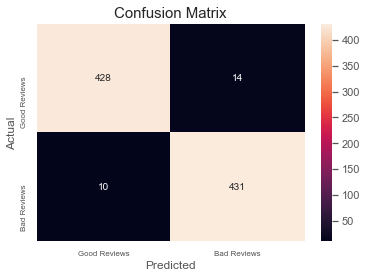

In [266]:
# Print metrics
class_conf(y_val,y_pred_class)

In [267]:
# Summarised results
mod1_results = metric_results(y_val,y_pred_class)
mod1_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.972825,0.968539,0.977324,0.972912,0.972825


## Sentiment Model 2

In [268]:
model2 = Sequential()
model2.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model2.add(Flatten())
model2.add(Dense(64, activation='relu', input_shape=(1600,)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 20, 16)            96000     
_________________________________________________________________
flatten_49 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                20544     
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 65        
Total params: 116,609
Trainable params: 116,609
Non-trainable params: 0
_________________________________________________________________
None


In [269]:
output_dir = 'model_output/SentimentModels2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [270]:
# Model using keras embeddings
history = model2.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size)

Epoch 1/50
883/883 - 1s - loss: 0.2565 - accuracy: 0.8872 - val_loss: 0.0945 - val_accuracy: 0.9728
Epoch 2/50
883/883 - 0s - loss: 0.0410 - accuracy: 0.9868 - val_loss: 0.0930 - val_accuracy: 0.9717
Epoch 3/50
883/883 - 0s - loss: 0.0080 - accuracy: 0.9986 - val_loss: 0.1195 - val_accuracy: 0.9660
Epoch 4/50
883/883 - 0s - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.1147 - val_accuracy: 0.9694
Epoch 5/50
883/883 - 0s - loss: 6.4938e-04 - accuracy: 1.0000 - val_loss: 0.1277 - val_accuracy: 0.9683
Epoch 6/50
883/883 - 0s - loss: 2.6682e-04 - accuracy: 1.0000 - val_loss: 0.1333 - val_accuracy: 0.9694
Epoch 7/50
883/883 - 0s - loss: 1.3474e-04 - accuracy: 1.0000 - val_loss: 0.1409 - val_accuracy: 0.9694


In [271]:
# Print training and test accuracies
loss, accuracy = model2.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9694


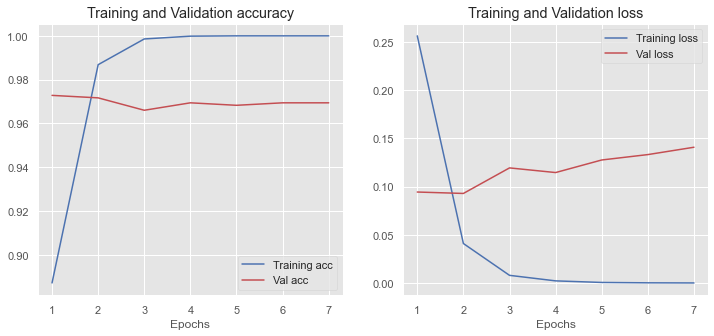

In [272]:
plot_history(history)

In [274]:
# Load model weights from epoch with best validation accuracy
model2.load_weights(output_dir+"/weights.01.hdf5")

In [275]:
# Get predicted y values and predicted classes
y_pred_prob = model2.predict(X_val_w)
y_pred_class = (model2.predict(X_val_w) > 0.5).astype("int32")

In [276]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.37729898],[0],0
1,[0.09437084],[0],0
2,[0.88918144],[1],1
3,[0.9969144],[1],1
4,[0.0006246865],[0],0


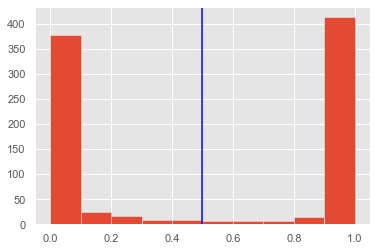

In [277]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       442
           1       0.97      0.98      0.97       441

    accuracy                           0.97       883
   macro avg       0.97      0.97      0.97       883
weighted avg       0.97      0.97      0.97       883



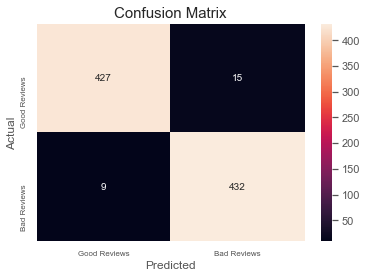

In [278]:
# Print metrics
class_conf(y_val,y_pred_class)

In [279]:
# Summarised results
mod2_results = metric_results(y_val,y_pred_class)
mod2_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.972828,0.966443,0.979592,0.972973,0.972828


In [280]:
model2.save('best_binary_sent_model.h5')

## Sentiment Model 3

In [281]:
# Network with a hidden layer with more neurons in the dense layer and with dropout of 50%
model3 = Sequential()
model3.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(rate=0.5))
model3.add(Dense(1, activation='sigmoid')) 
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 20, 16)            96000     
_________________________________________________________________
flatten_50 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               41088     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 129       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
None


In [282]:
output_dir = 'model_output/SentimentModels3'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [283]:
# Model using keras embeddings
history = model3.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size)

Epoch 1/50
883/883 - 1s - loss: 0.2699 - accuracy: 0.8800 - val_loss: 0.1044 - val_accuracy: 0.9604
Epoch 2/50
883/883 - 0s - loss: 0.0460 - accuracy: 0.9853 - val_loss: 0.0901 - val_accuracy: 0.9683
Epoch 3/50
883/883 - 0s - loss: 0.0129 - accuracy: 0.9967 - val_loss: 0.0963 - val_accuracy: 0.9728
Epoch 4/50
883/883 - 0s - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.1177 - val_accuracy: 0.9683
Epoch 5/50
883/883 - 0s - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1255 - val_accuracy: 0.9706
Epoch 6/50
883/883 - 1s - loss: 3.8504e-04 - accuracy: 1.0000 - val_loss: 0.1357 - val_accuracy: 0.9717
Epoch 7/50
883/883 - 0s - loss: 2.1905e-04 - accuracy: 1.0000 - val_loss: 0.1440 - val_accuracy: 0.9740


In [284]:
# Print training and test accuracies
loss, accuracy = model3.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9740


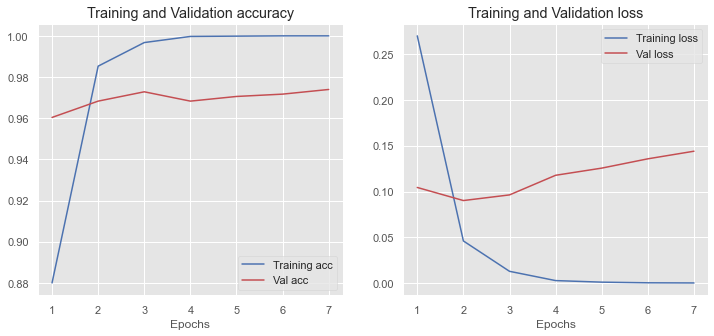

In [285]:
plot_history(history)

In [290]:
# Load model weights from epoch with best validation accuracy
model3.load_weights(output_dir+"/weights.07.hdf5")

In [291]:
# Get predicted y values and predicted classes
y_pred_prob = model3.predict(X_val_w)
y_pred_class = (model3.predict(X_val_w) > 0.5).astype("int32")

In [292]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.0014020801],[0],0
1,[3.1046784e-05],[0],0
2,[0.8602626],[1],1
3,[0.9999995],[1],1
4,[8.006168e-10],[0],0


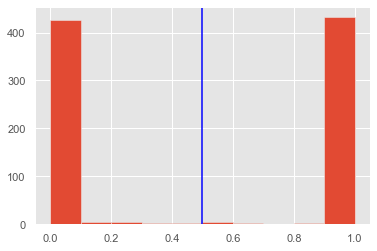

In [293]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       442
           1       0.97      0.98      0.97       441

    accuracy                           0.97       883
   macro avg       0.97      0.97      0.97       883
weighted avg       0.97      0.97      0.97       883



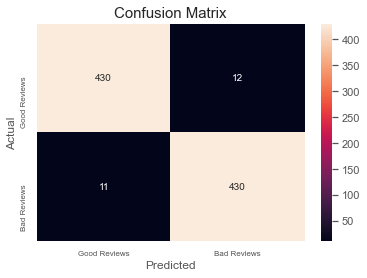

In [294]:
# Print metrics
class_conf(y_val,y_pred_class)

In [295]:
# Summarised results
mod3_results = metric_results(y_val,y_pred_class)
mod3_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.973954,0.972851,0.975057,0.973952,0.973954


## Sentiment Model 4

In [296]:
# Dense model with 2 hidden dense layers and dropout on each
model4 = Sequential()
model4.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(rate=0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(rate = 0.5))
model4.add(Dense(1, activation='sigmoid')) 
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_51 (Embedding)     (None, 20, 16)            96000     
_________________________________________________________________
flatten_51 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)               41088     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)               

In [297]:
output_dir = 'model_output/SentimentModels4'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [298]:
# Model using keras embeddings
history = model4.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size)

Epoch 1/50
883/883 - 1s - loss: 0.2744 - accuracy: 0.8577 - val_loss: 0.1046 - val_accuracy: 0.9683
Epoch 2/50
883/883 - 1s - loss: 0.0429 - accuracy: 0.9873 - val_loss: 0.1041 - val_accuracy: 0.9672
Epoch 3/50
883/883 - 1s - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.1375 - val_accuracy: 0.9728
Epoch 4/50
883/883 - 1s - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1508 - val_accuracy: 0.9785
Epoch 5/50
883/883 - 1s - loss: 0.0039 - accuracy: 0.9983 - val_loss: 0.1943 - val_accuracy: 0.9706
Epoch 6/50
883/883 - 1s - loss: 4.9497e-04 - accuracy: 0.9999 - val_loss: 0.2193 - val_accuracy: 0.9706
Epoch 7/50
883/883 - 1s - loss: 9.1645e-04 - accuracy: 0.9999 - val_loss: 0.2308 - val_accuracy: 0.9728


In [299]:
# Print training and test accuracies
loss, accuracy = model4.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9999
Testing Accuracy:  0.9728


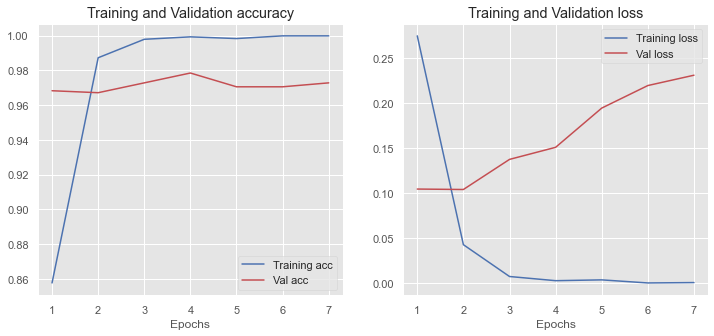

In [300]:
plot_history(history)

In [302]:
# Load model weights from epoch with best validation accuracy
model4.load_weights(output_dir+"/weights.04.hdf5")

In [303]:
# Get predicted y values and predicted classes
y_pred_prob = model4.predict(X_val_w)
y_pred_class = (model4.predict(X_val_w) > 0.5).astype("int32")

In [304]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.0020002127],[0],0
1,[7.705735e-05],[0],0
2,[0.99911],[1],1
3,[0.9999992],[1],1
4,[6.125019e-11],[0],0


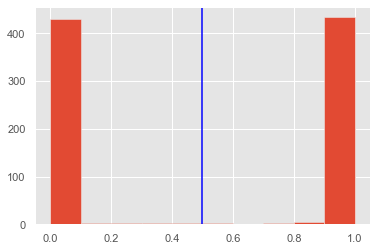

In [305]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       442
           1       0.98      0.98      0.98       441

    accuracy                           0.98       883
   macro avg       0.98      0.98      0.98       883
weighted avg       0.98      0.98      0.98       883



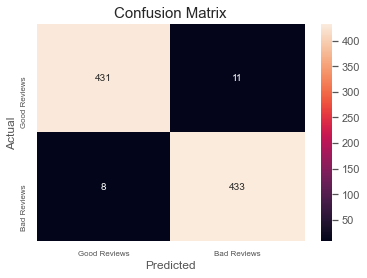

In [306]:
# Print metrics
class_conf(y_val,y_pred_class)

In [307]:
# Summarised results
mod4_results = metric_results(y_val,y_pred_class)
mod4_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.978486,0.975225,0.981859,0.978531,0.978486


##  Sentiment Model 5

In [308]:
# Dense model with 2 hidden dense layers and dropout on each
model5 = Sequential()
model5.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model5.add(Flatten())
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(rate=0.5))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(rate = 0.5))
model5.add(Dense(128,activation = 'relu'))
model5.add(Dense(1, activation='sigmoid')) 
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model5.summary())

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 20, 16)            96000     
_________________________________________________________________
flatten_52 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               164352    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 128)             

In [309]:
output_dir = 'model_output/SentimentModels5'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [310]:
# Model using keras embeddings
history = model5.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size)

Epoch 1/50
883/883 - 1s - loss: 0.2415 - accuracy: 0.8846 - val_loss: 0.1283 - val_accuracy: 0.9558
Epoch 2/50
883/883 - 1s - loss: 0.0347 - accuracy: 0.9891 - val_loss: 0.1242 - val_accuracy: 0.9581
Epoch 3/50
883/883 - 1s - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.1880 - val_accuracy: 0.9638
Epoch 4/50
883/883 - 1s - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.2146 - val_accuracy: 0.9694
Epoch 5/50
883/883 - 1s - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.2351 - val_accuracy: 0.9604
Epoch 6/50
883/883 - 1s - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.1770 - val_accuracy: 0.9615
Epoch 7/50
883/883 - 1s - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.2103 - val_accuracy: 0.9638


In [311]:
# Print training and test accuracies
loss, accuracy = model5.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model5.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9999
Testing Accuracy:  0.9638


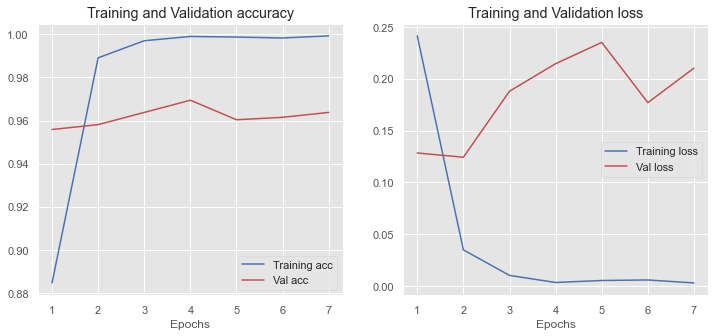

In [312]:
plot_history(history)

In [314]:
# Load model weights from epoch with best validation accuracy
model5.load_weights(output_dir+"/weights.03.hdf5")

In [315]:
# Get predicted y values and predicted classes
y_pred_prob = model5.predict(X_val_w)
y_pred_class = (model5.predict(X_val_w) > 0.5).astype("int32")

In [316]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.016645998],[0],0
1,[0.00080010295],[0],0
2,[0.9877714],[1],1
3,[0.99999976],[1],1
4,[3.0946345e-10],[0],0


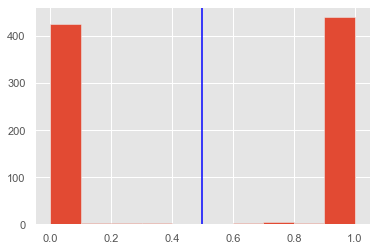

In [317]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       442
           1       0.95      0.98      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



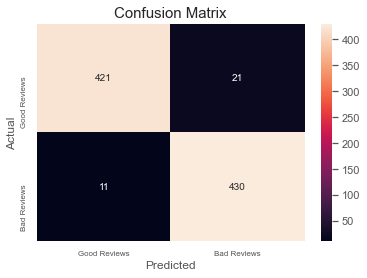

In [318]:
# Print metrics
class_conf(y_val,y_pred_class)

In [319]:
# Summarised results
mod5_results = metric_results(y_val,y_pred_class)
mod5_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.963773,0.953437,0.975057,0.964126,0.963773


# Section 4: Summary of results

In [320]:
models = ["Model1","Model2","Model3","Model4","Model5"]
summary_table = pd.concat([mod1_results,mod2_results,mod3_results,mod4_results,mod5_results])
summary_table.set_index([models],inplace = True)
summary_table.to_csv("results_sentiment.csv")
summary_table.sort_values(by = "Accuracy",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Model4,0.978486,0.975225,0.981859,0.978531,0.978486
Model3,0.973954,0.972851,0.975057,0.973952,0.973954
Model2,0.972828,0.966443,0.979592,0.972973,0.972828
Model1,0.972825,0.968539,0.977324,0.972912,0.972825
Model5,0.963773,0.953437,0.975057,0.964126,0.963773


# Section 5: Hyperparameter Tuning

In [396]:
def network_model(learning_rate, initializer, dropout_rate, activation):
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
    model.add(Flatten())
    model.add(Dense(128,activation=activation,kernel_initializer=initializer ))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(rate = dropout_rate))
    model.add(Dense(1, activation='sigmoid')) 
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use KerasClassifier to convert to sci-kit learn implementation to allow tuning to be easier
model = KerasClassifier(build_fn = network_model, verbose = 0)

In [397]:
learning_rate = [0.001, 0.01, 0.1]
initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
batch_size = [8,16,32]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
epochs = [10,20,50,100]
batch_size = [8,16,32]

param_distribs = {"learning_rate":learning_rate, "initializer":initializer,"batch_size":batch_size,
                  "dropout_rate" :dropout_rate, "activation":activation,"epochs" : epochs}
clf = RandomizedSearchCV(model, param_distribs, cv = 3,n_jobs = -1)
grid_result = clf.fit(X_train_w, y_train)

In [398]:
# Extract results from the gridsearch

# Set the scores
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# Set the parameters
Act = [i['activation'] for i in params]
learning_rate = [i['learning_rate'] for i in params]
drop = [i['dropout_rate'] for i in params]
batch = [i['batch_size'] for i in params]
epoch = [i['epochs'] for i in params]
kern = [i['initializer'] for i in params]

# Show in dataframe and sort
cv_results = pd.DataFrame({'Mean Accuracy':means, 'Std':stds, 'Activation':Act, 'Learning Rate': learning_rate, 
                           'Batch size': batch, 'Epoch':epoch,'Kernel Init':kern,'Dropout': drop})
cv_results.sort_values(by=['Mean Accuracy'],ascending=False)

,Mean Accuracy,Std,Activation,Learning Rate,Batch size,Epoch,Kernel Init,Dropout
1,0.960363,0.004104,sigmoid,0.001,8,20,uniform,0.1
8,0.960080,0.004760,sigmoid,0.001,16,50,lecun_uniform,0.5
5,0.958947,0.003225,softsign,0.001,32,10,glorot_uniform,0.5
0,0.958806,0.001924,linear,0.001,32,20,zero,0.4
9,0.957815,0.002500,linear,0.100,32,100,he_uniform,0.9
4,0.957532,0.002747,linear,0.001,32,10,glorot_uniform,0.7
7,0.956540,0.001452,softsign,0.010,8,50,he_normal,0.6
6,0.956399,0.003022,tanh,0.010,32,10,glorot_uniform,0.9
2,0.952152,0.002226,tanh,0.010,16,50,glorot_normal,0.0
3,0.950170,0.002594,linear,0.100,16,100,uniform,0.5


No improvement to accuracy

# Section 6: Best Model against the Test Set

In [399]:
model4.load_weights('model_output/SentimentModels4/weights.04.hdf5')

In [400]:
y_pred_prob = model4.predict(X_test_w)
y_pred_class = (model4.predict(X_test_w) > 0.5).astype("int32")

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       441
           1       0.97      0.95      0.96       442

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



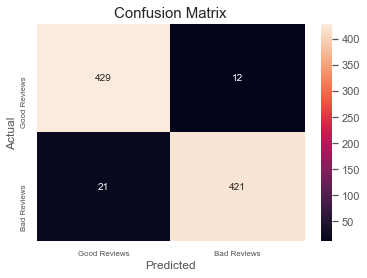

In [401]:
# Print metrics
class_conf(y_test,y_pred_class)

In [403]:
mod6 = metric_results(y_test,y_pred_class)
mod6.index = ["Binary Sentiment NN Model 4"]
mod6

,Accuracy,Precision,Recall,F1,ROCAUC
Binary Sentiment NN Model 4,0.962639,0.972286,0.952489,0.962286,0.962639
